In [ ]:
# Cell 1: Imports
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from zipfile import ZipFile


In [ ]:
# Cell 2: Data Extraction from Zip
with ZipFile('new.zip', 'r') as Zipobj:
    Zipobj.extractall("vehicles")


In [ ]:

# Cell 3: List Contents of the Main Folder
main_folder_path = "/content/vehicles/myproj"
main_folder_contents = os.listdir(main_folder_path)
print("Contents of the main folder:")
print(main_folder_contents)

Contents of the main folder:
['auto', 'cycle', 'cars', 'bikes']


In [ ]:

# Cell 4: Count Number of Images in Each Class
for class_name in main_folder_contents:
    class_path = os.path.join(main_folder_path, class_name)

    if os.path.isdir(class_path):
        num_images = len([file for file in os.listdir(class_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"Class {class_name} has {num_images} images.")

Class auto has 54 images.
Class cycle has 35 images.
Class cars has 410 images.
Class bikes has 401 images.


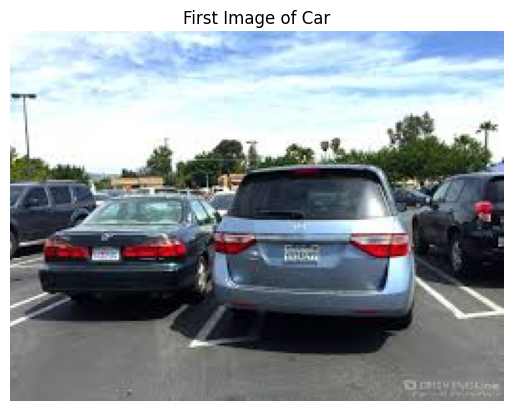

In [ ]:
# Cell 5: Display First Image of Cars
subfolder_name = "cars"
subfolder_path = os.path.join(main_folder_path, subfolder_name)
first_car_image_path = os.path.join(subfolder_path, os.listdir(subfolder_path)[0])
first_car_image = Image.open(first_car_image_path)
plt.imshow(first_car_image)
plt.title("First Image of Car")
plt.axis('off')
plt.show()

In [ ]:
# Cell 6: Load and Preprocess Images
def load_and_preprocess_images(folder_path, target_size=(224, 224)):
    images = []
    labels = []

    class_mapping = ["cars", "bikes", "auto", "cycle"]

    for class_label in class_mapping:
        class_folder_path = os.path.join(folder_path, class_label)
        if os.path.exists(class_folder_path):
            for filename in os.listdir(class_folder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(class_folder_path, filename)
                    img = image.load_img(file_path, target_size=target_size)
                    img_array = image.img_to_array(img)
                    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

                    images.append(img_array)
                    labels.append(class_mapping.index(class_label))

    return np.array(images), to_categorical(np.array(labels), num_classes=len(class_mapping))

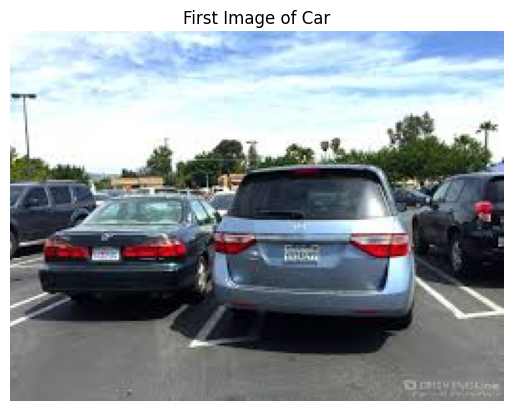

In [ ]:
# Cell 7: Display First Image of Cars (Alternate Method)
subfolder_name = "cars"
subfolder_path = os.path.join(main_folder_path, subfolder_name)
first_car_image_path = os.path.join(subfolder_path, os.listdir(subfolder_path)[0])
first_car_image = Image.open(first_car_image_path).convert("RGBA")
plt.imshow(first_car_image)
plt.title("First Image of Car")
plt.axis('off')
plt.show()

In [ ]:
# Cell 8: Load and Preprocess Images from 'vehicles' Dataset
images, labels = load_and_preprocess_images(main_folder_path)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Cell 9: ResNet Model
class_mapping = ["cars", "bikes", "auto", "cycle"]

resnet_model = Sequential()
pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(len(class_mapping), activation='softmax'))
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history=resnet_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/5
23/23 [==============================] - 201s 9s/step - loss: 0.2088 - accuracy: 0.9500 - val_loss: 0.0172 - val_accuracy: 0.9944
Epoch 2/5
23/23 [==============================] - 172s 8s/step - loss: 0.0182 - accuracy: 0.9917 - val_loss: 0.0550 - val_accuracy: 0.9944
Epoch 3/5
23/23 [==============================] - 172s 8s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0816 - val_accuracy: 0.9889
Epoch 4/5
23/23 [==============================] - 169s 7s/step - loss: 2.7984e-04 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 0.9944
Epoch 5/5
23/23 [==============================] - 173s 8s/step - loss: 9.2428e-05 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9944


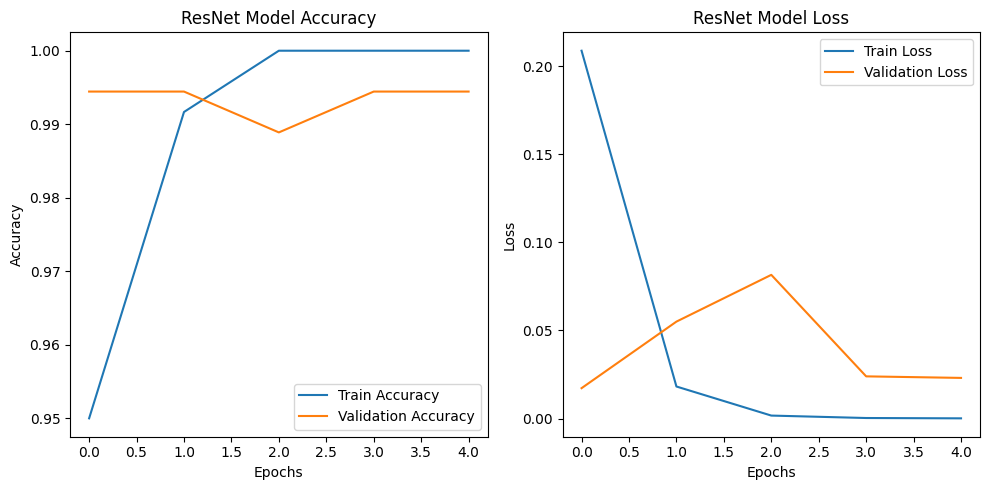

In [ ]:
#Display Training History for ResNet Model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

#  Evaluate ResNet Model
loss, accuracy = resnet_model.evaluate(X_test, y_test)
print(f"ResNet Model - Test Loss: {loss}, Test Accuracy: {accuracy}")

6/6 [==============================] - 35s 6s/step - loss: 0.0231 - accuracy: 0.9944
ResNet Model - Test Loss: 0.023053018376231194, Test Accuracy: 0.9944444298744202


In [ ]:
#  Confusion Matrix for ResNet Model
y_pred_resnet = resnet_model.predict(X_test)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)
y_true_classes_resnet = np.argmax(y_test, axis=1)
conf_matrix_resnet = confusion_matrix(y_true_classes_resnet, y_pred_classes_resnet)
plt.figure(figsize=(8, 6))
plt.show()

6/6 [==============================] - 33s 5s/step


<Figure size 800x600 with 0 Axes>

1/1 [==============================] - 0s 204ms/step


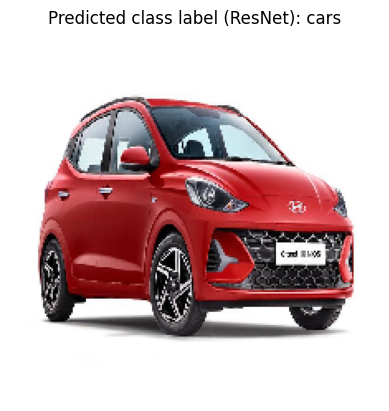

In [ ]:
# Assuming you have a new image you want to predict
new_image_path_resnet = "/content/Hyundai-Grand-i10-Nios-200120231541.jpg"

# Load and preprocess the new image for ResNet
new_image_resnet = image.load_img(new_image_path_resnet, target_size=(224, 224))
new_image_array_resnet = image.img_to_array(new_image_resnet)
new_image_array_resnet = np.expand_dims(new_image_array_resnet, axis=0)
new_image_array_resnet = tf.keras.applications.resnet.preprocess_input(new_image_array_resnet)

# Make predictions using ResNet
predictions_resnet = resnet_model.predict(new_image_array_resnet)

# Get the predicted class index for ResNet
predicted_class_index_resnet = np.argmax(predictions_resnet)

# Map the index to the class label for ResNet
class_mapping_resnet = ["cars", "bikes", "auto", "cycle"]
predicted_class_label_resnet = class_mapping_resnet[predicted_class_index_resnet]

# Display the new image along with prediction for ResNet
plt.imshow(new_image_resnet)
plt.title(f"Predicted class label (ResNet): {predicted_class_label_resnet}")
plt.axis('off')
plt.show()


In [ ]:

# Train MobileNetV2 Model
mobilenet_model = Sequential()
pretrained_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
for layer in pretrained_model_mobilenet.layers:
    layer.trainable = False

mobilenet_model.add(pretrained_model_mobilenet)
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(len(class_mapping), activation='softmax'))
mobilenet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_mobilenet = mobilenet_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/5
23/23 [==============================] - 47s 2s/step - loss: 0.5369 - accuracy: 0.8528 - val_loss: 0.3156 - val_accuracy: 0.8611
Epoch 2/5
23/23 [==============================] - 41s 2s/step - loss: 0.1673 - accuracy: 0.9403 - val_loss: 0.1789 - val_accuracy: 0.9389
Epoch 3/5
23/23 [==============================] - 41s 2s/step - loss: 0.0832 - accuracy: 0.9667 - val_loss: 0.1701 - val_accuracy: 0.9389
Epoch 4/5
23/23 [==============================] - 41s 2s/step - loss: 0.0286 - accuracy: 0.9986 - val_loss: 0.1151 - val_accuracy: 0.9500
Epoch 5/5
23/23 [==============================] - 40s 2s/step - loss: 0.0144 - accuracy: 0.9986 - val_loss: 0.1250 - val_accuracy: 0.9444


In [ ]:


# Evaluate MobileNetV2 Model
loss_mobilenet, accuracy_mobilenet = mobilenet_model.evaluate(X_test, y_test)
print(f"MobileNetV2 Model - Test Loss: {loss_mobilenet}, Test Accuracy: {accuracy_mobilenet}")

6/6 [==============================] - 7s 1s/step - loss: 0.1250 - accuracy: 0.9444
MobileNetV2 Model - Test Loss: 0.12495122849941254, Test Accuracy: 0.9444444179534912


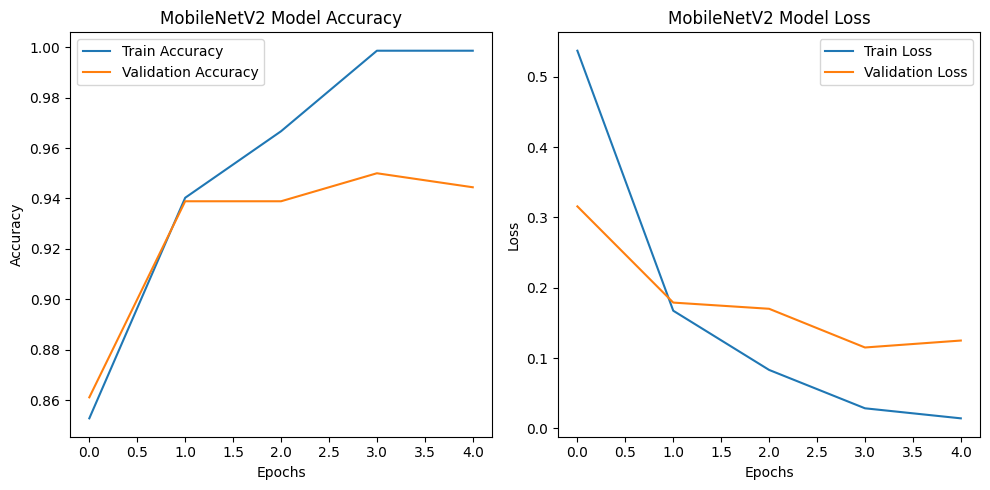

In [ ]:

#  Display Training History for MobileNetV2 Model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
# Cell 16: Predict New Image using MobileNetV2
new_image_path = "/content/Hyundai-Grand-i10-Nios-200120231541.jpg"

# Load and preprocess the new image for MobileNetV2
new_image = image.load_img(new_image_path, target_size=(224, 224))
new_image_array = image.img_to_array(new_image)
new_image_array = np.expand_dims(new_image_array, axis=0)
new_image_array = tf.keras.applications.mobilenet_v2.preprocess_input(new_image_array)

# Make predictions using MobileNetV2
predictions_mobilenet = mobilenet_model.predict(new_image_array)

# Get the predicted class index for MobileNetV2
predicted_class_index_mobilenet = np.argmax(predictions_mobilenet)

# Map the index to the class label for MobileNetV2
class_mapping_mobilenet = ["cars", "bikes", "auto", "cycle"]
predicted_class_label_mobilenet = class_mapping_mobilenet[predicted_class_index_mobilenet]

# Display the new image along with prediction
plt.imshow(new_image)
plt.title(f"Predicted class label (MobileNetV2): {predicted_class_label_mobilenet}")
plt.axis('off')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/sportscar_13620490_1000 (1).jpg'